## COMP 541 - DEEP Learning Project

In [28]:
import Pkg; Pkg.add("IterTools")
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots
using DelimitedFiles, Statistics, Random
dataset_directory_path = "../Data/Experiments3controller"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`


7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

## Data Preprocessing

In [2]:
function split_and_convert(string_array)
    Rlength = length(string_array)
    Clength = length(split(string_array[1]," "))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i]," "))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [92]:
## Computing the Derivative of X to get Velocity
function take_derivative(x,t)
   v = zeros(size(t))
   for i in 2:length(t)
       velocity = (x[i] - x[i-1])/(t[i]-t[i-1])
       isnan(velocity) ? v[i] = 0 : v[i] = velocity
    end
    return v
end

take_derivative (generic function with 1 method)

### Read and Assign all of the data

In [169]:
X = Array{Float64}(undef, 0, 12)
X_selected =  Array{Float64}(undef, 0, 4)
seperator  = Array{Float64}(undef,0) #To find out the length of time series

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    
    for raw_txt_files in participant_directory
        txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
        txt_file_directory = readdir(txt_file_directory_path)
        #Txt Files:"actJPos.txt", "controllerData.txt", "desCPos.txt", "desJPos.txt", "expDetails.txt", "timeData.txt"
        
        #expDetails.txt
        exp_detail_file = open(joinpath(txt_file_directory_path, txt_file_directory[5]),"r")
        exp_details = map(x->tryparse(Float64,x),split(readline(exp_detail_file)," "))
        close(exp_detail_file)
        
        #timeData.txt
        time_detail_file = open(joinpath(txt_file_directory_path, txt_file_directory[6]),"r")
        time_data = split_and_convert(readlines(time_detail_file))
        close(time_detail_file)
        
        initial_time = time_data[1,2];
        time_data[:,2] = time_data[:,2] .- initial_time
        
        #ControllerData.txt
        controller_detail_file = open(joinpath(txt_file_directory_path, txt_file_directory[2]),"r")
        controller_data = split_and_convert(readlines(controller_detail_file))
        close(controller_detail_file)
        
        #desCPos.txt
        desCPos_detail_file = open(joinpath(txt_file_directory_path, txt_file_directory[3]),"r")
        measurements_data = split_and_convert(readlines(desCPos_detail_file))
        close(desCPos_detail_file)
        
        trial_size = 14224 #size(time_data)[1] #determine the time 
        trim_size = collect(1:trial_size)
        
        #To make same size with the other matrices
        exp_data = repeat(exp_details,1,trial_size)'
        subject_data = fill(participant_index,trial_size,1)
        velocity_data = take_derivative(measurements_data[trim_size,1],time_data[trim_size,2])
 
        #1        2       3     4 5 6 7 8 9   10   11  12
        #subject exp controller t m b a x v ffint fint fh
        temp = [subject_data exp_data[trim_size,1] exp_data[trim_size,5] time_data[trim_size,2] controller_data[trim_size,:] measurements_data[trim_size,:]]
        X = [X; temp]
        
        #1     2     3        4
        #t     v    f_h     f_int     
        temp_selected = [time_data[trim_size,2] velocity_data measurements_data[trim_size,4]  measurements_data[trim_size,5]]
        X_selected = [X_selected;temp_selected]
        
        seperator = [seperator; trial_size]
    end   
end

### Checking the derived data

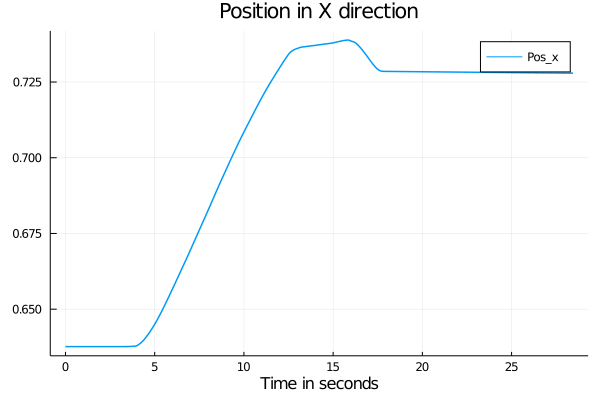

In [172]:
plot(X[1:14224,4],X[1:14224,8], title = "Position in X direction", label = "Pos_x", lw = 1.5)
xlabel!("Time in seconds")

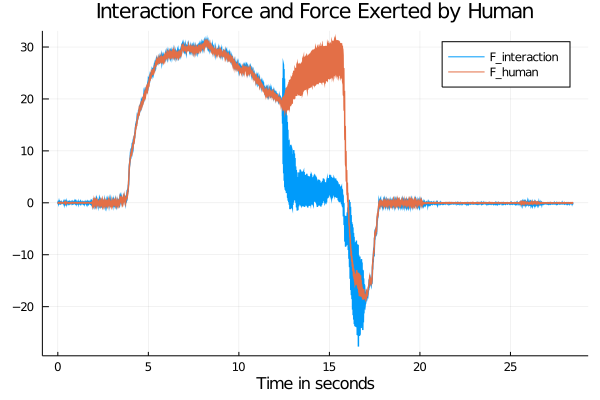

In [174]:
plot(X[1:14224,4],X[1:14224,11], title = "Interaction Force and Force Exerted by Human", label = "F_interaction" ,lw = 1.5, fmt = :png)
plot!(X[1:14224,4],X[1:14224,12], label = "F_human", lw = 1.5)
xlabel!("Time in seconds")

### Normalization

In [152]:
function normalize(x)
    return (x .- mean(x,dims=1)) ./ std(x,dims=1);
end

normalize (generic function with 1 method)

In [175]:
X_selected =[X_selected[:,1] normalize(X_selected[:,2:end])]; 

### Labeling 

#### Classification the data using Rule-Based Method.
| Subtask's Border | Rule   |
|------|------|
| Holding -> Free Movement  | F_h > 0.5 |
| Free Movement -> Drilling | high frequencies of F_h and F_int |

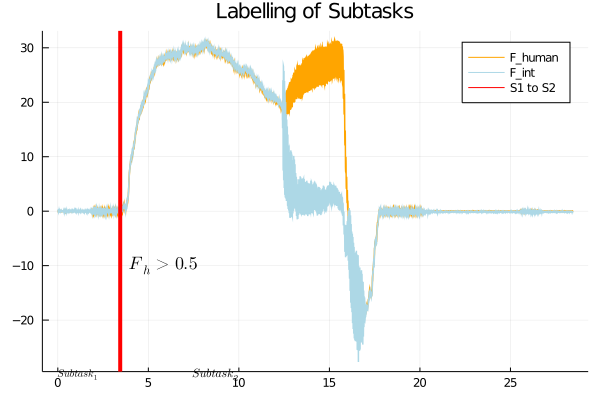

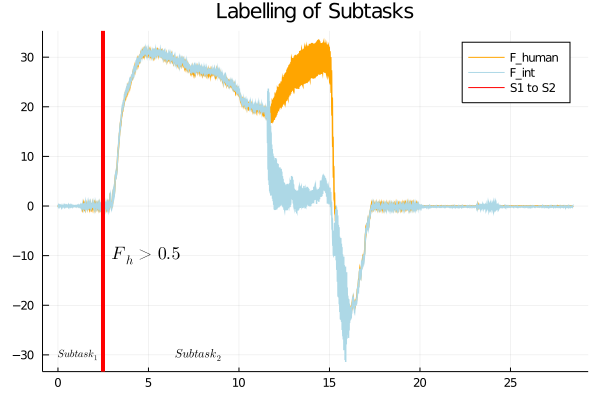

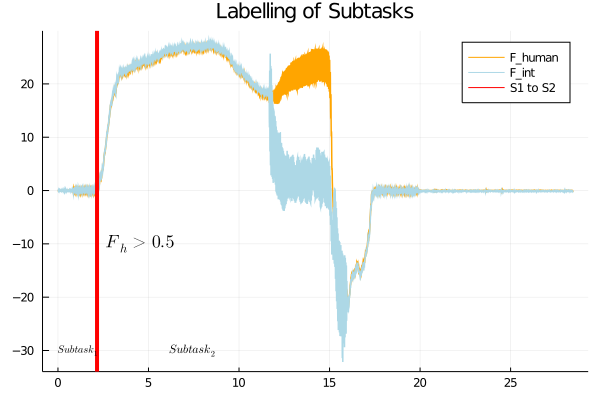

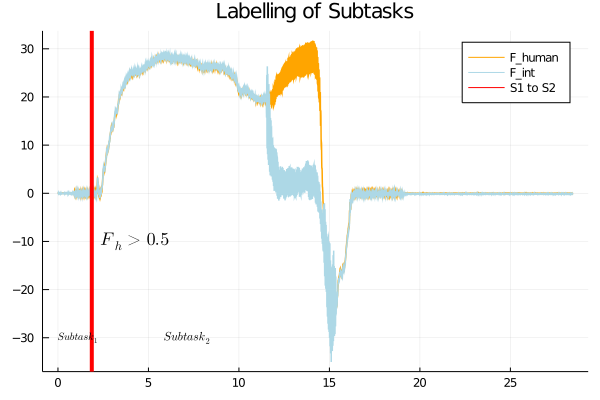

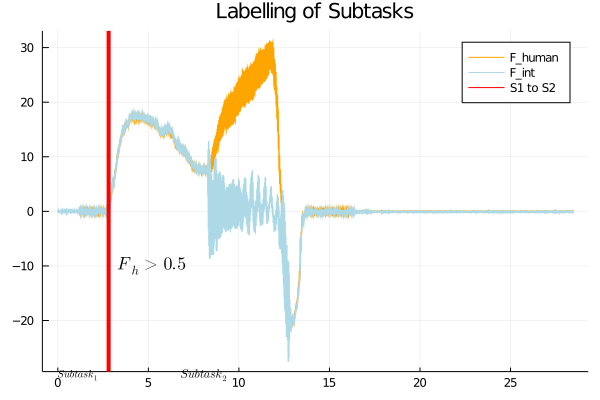

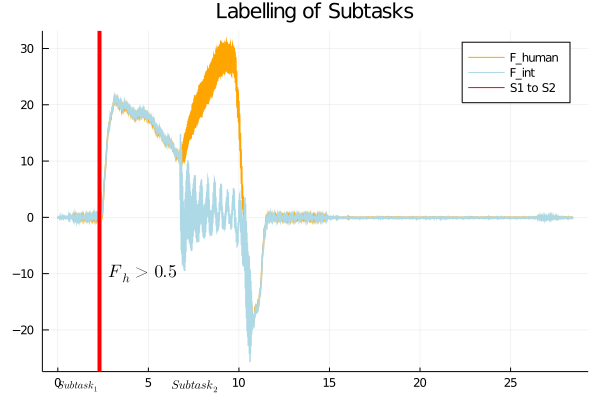

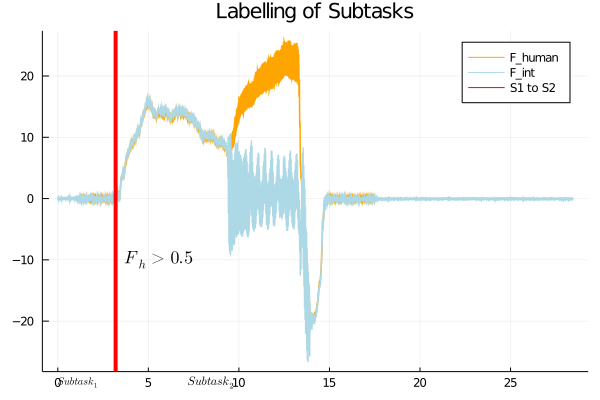

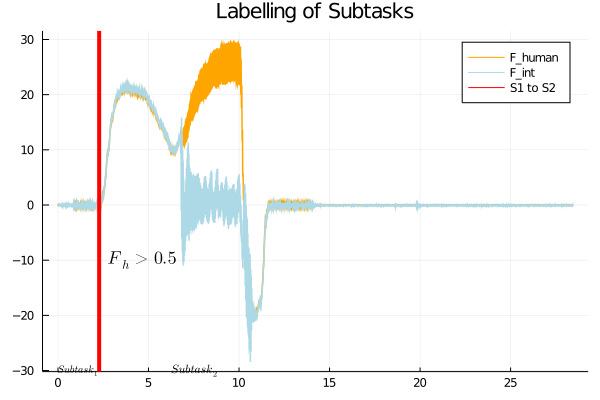

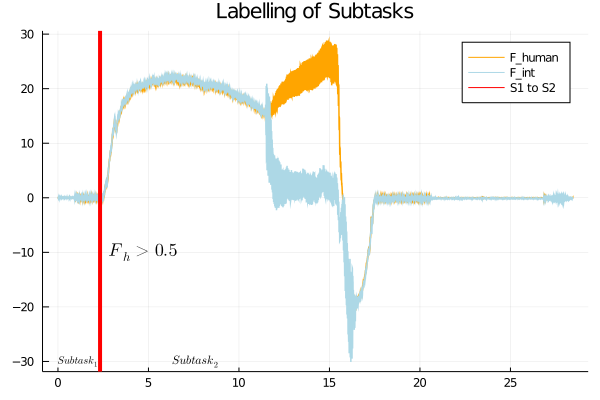

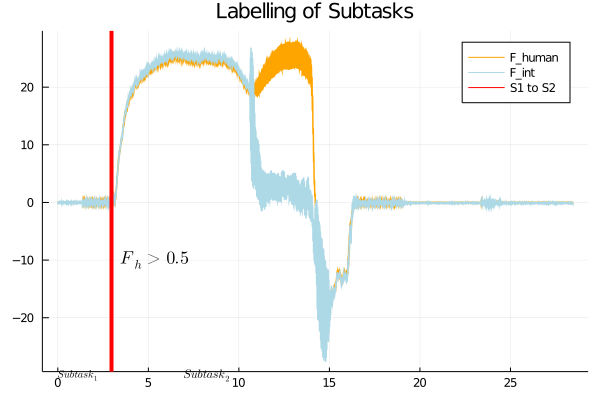

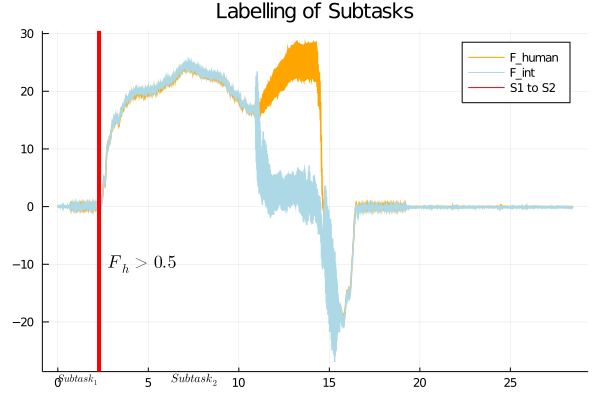

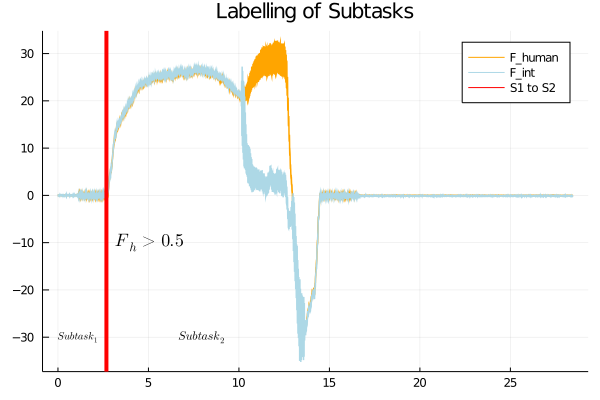

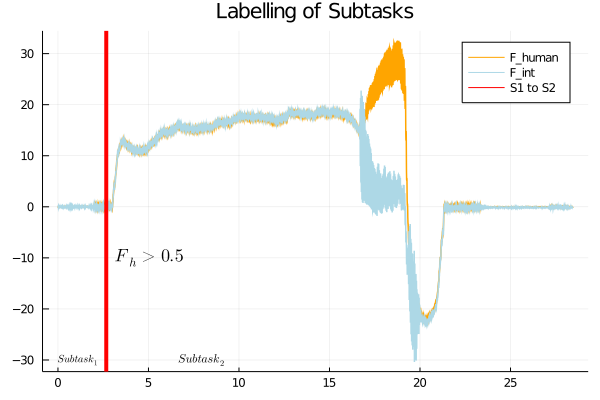

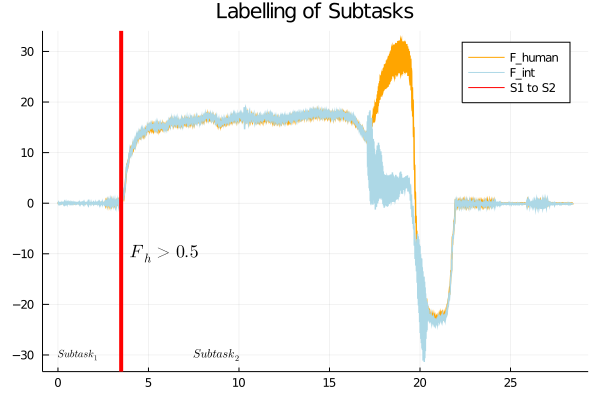

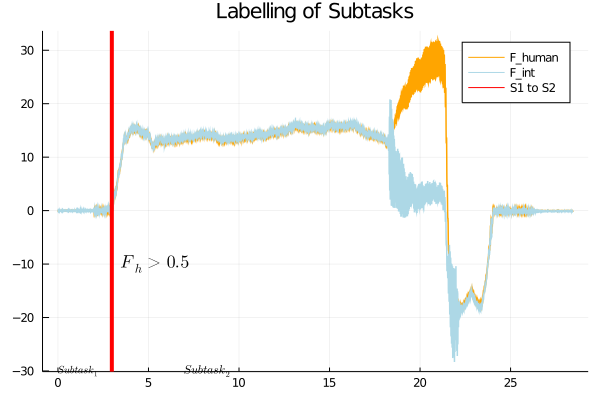

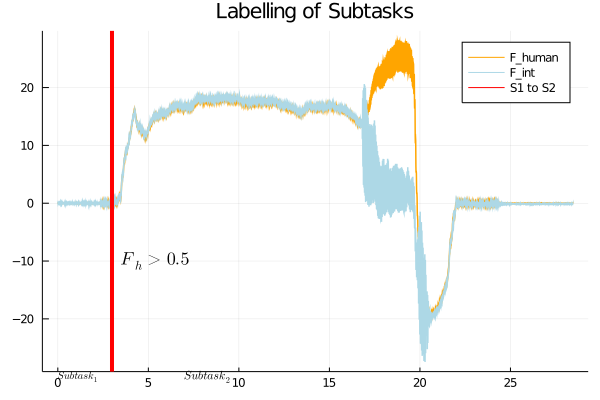

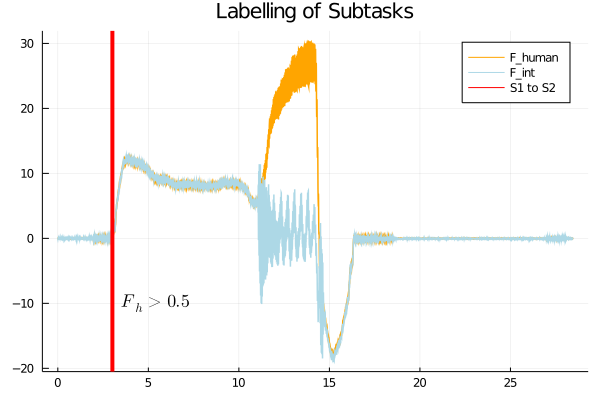

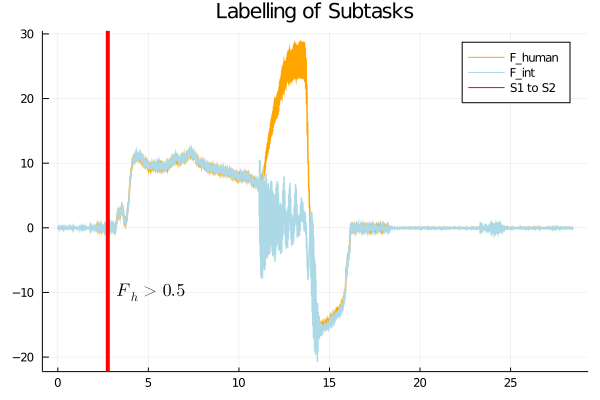

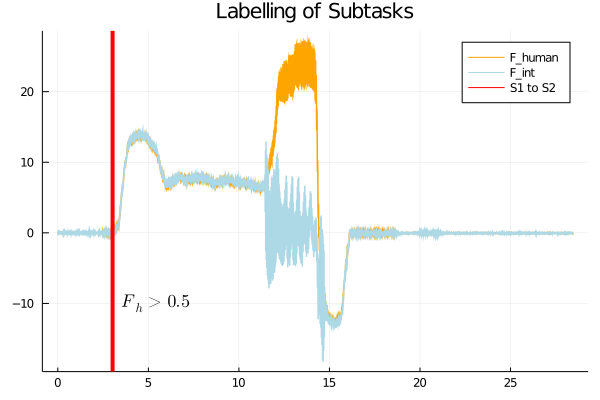

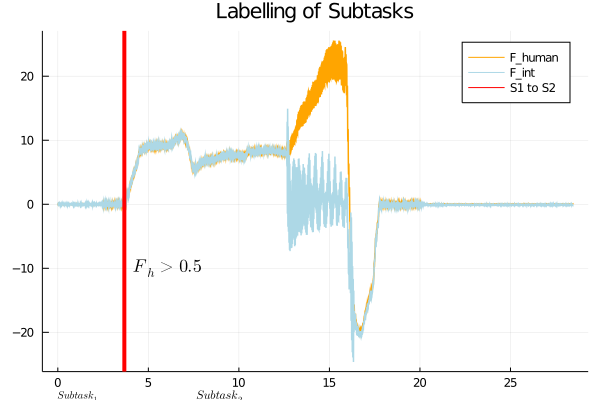

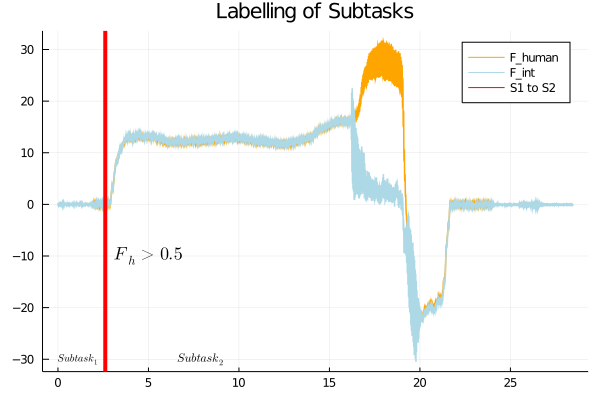

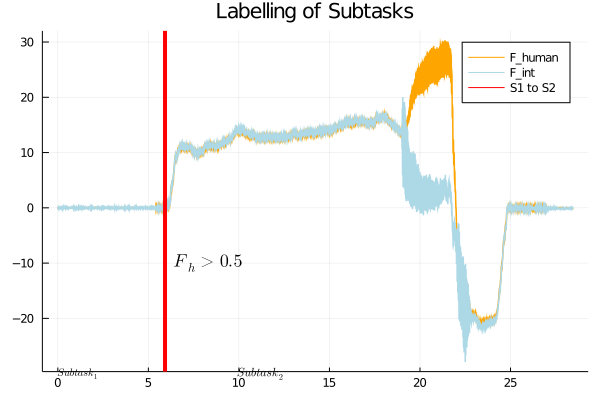

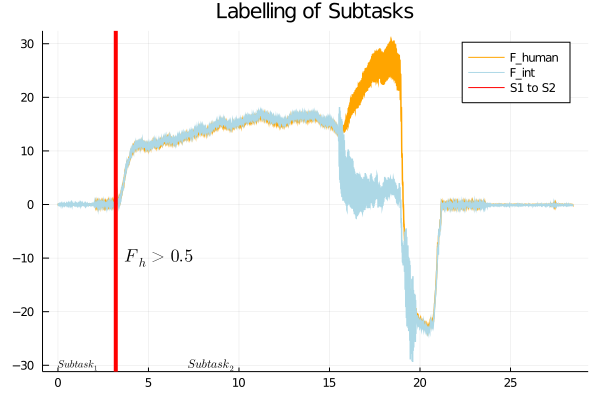

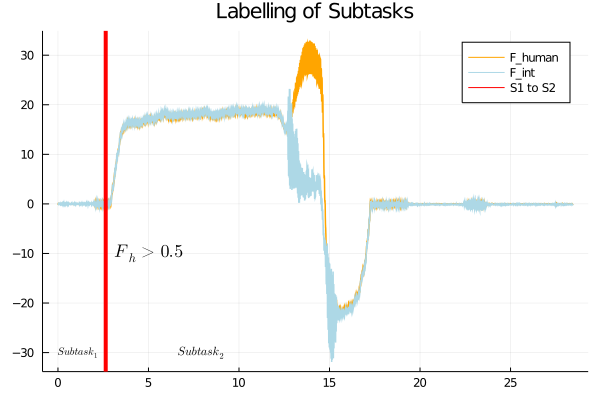

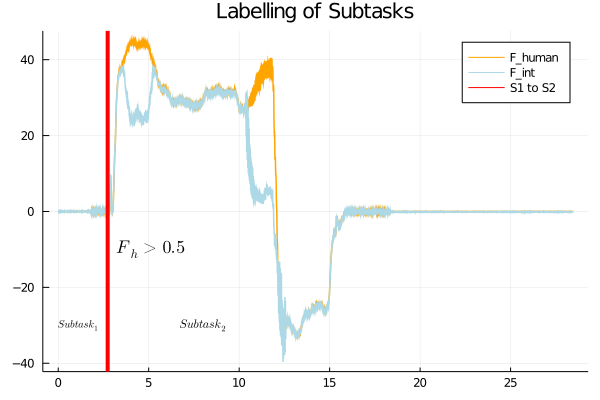

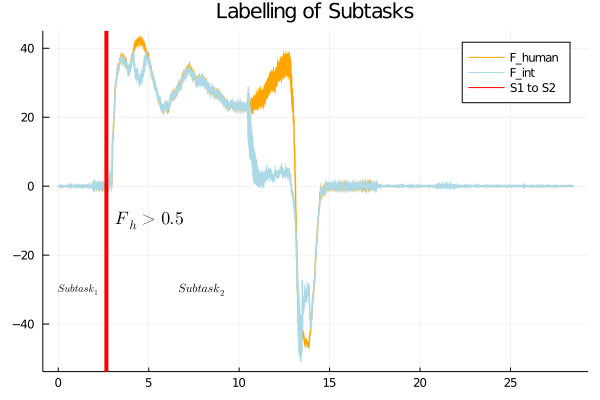

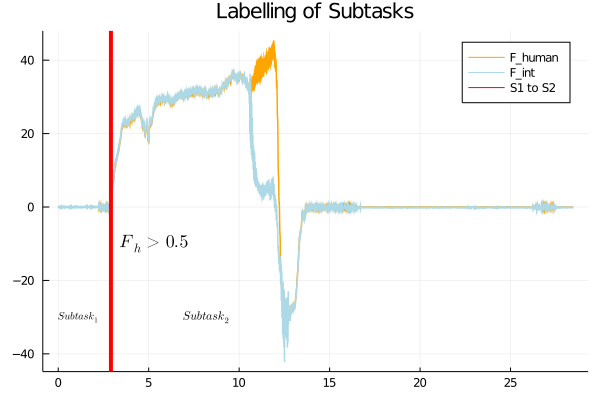

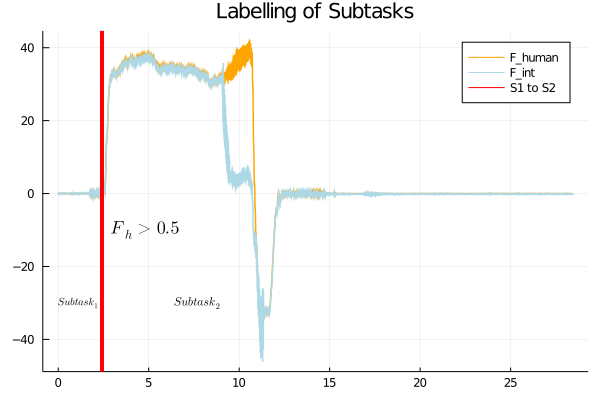

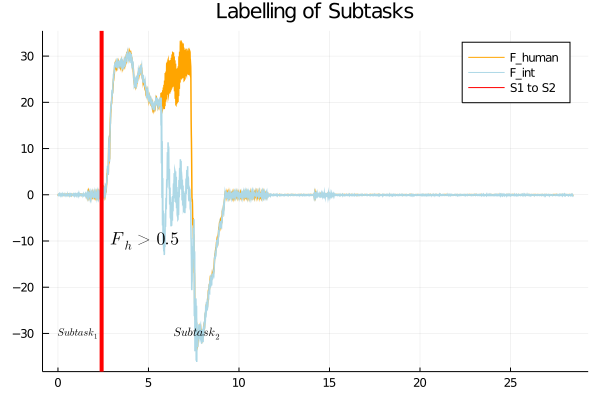

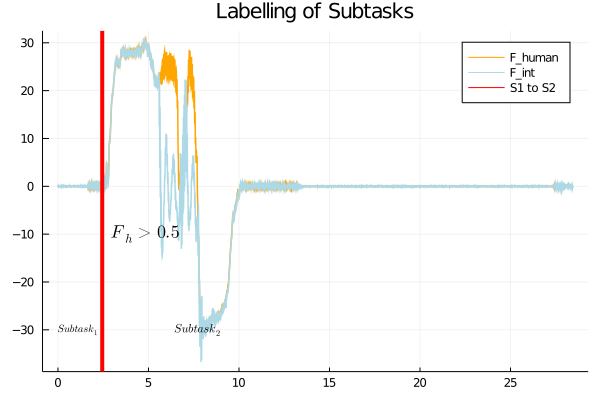

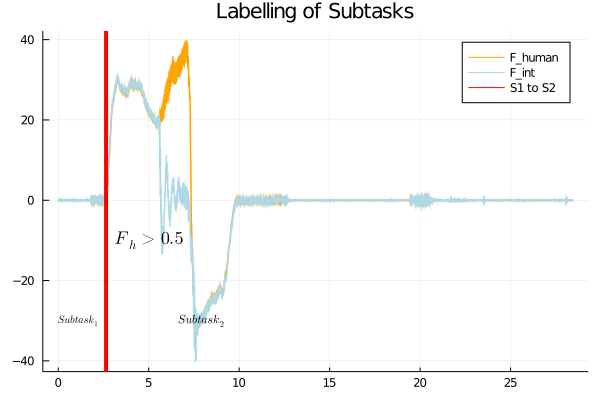

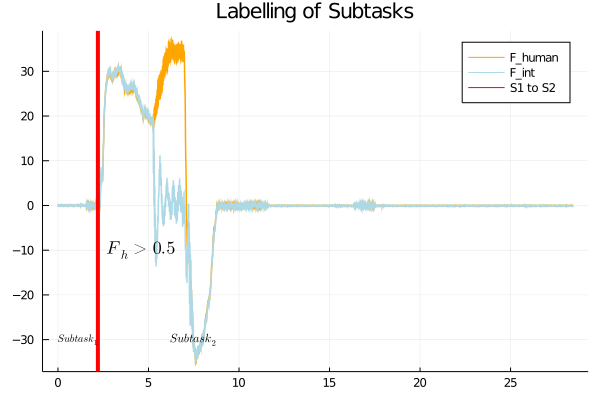

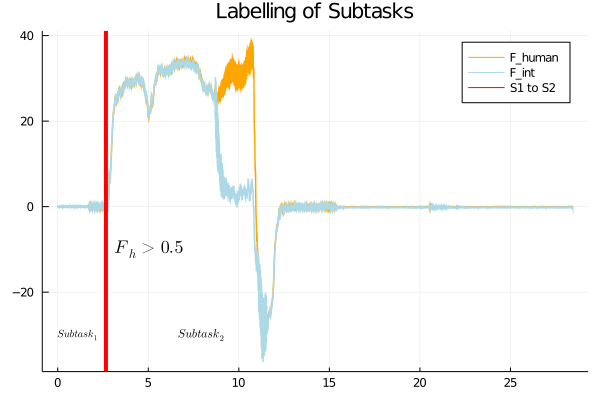

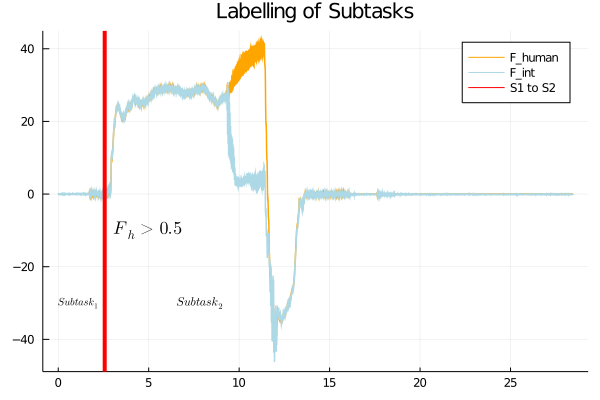

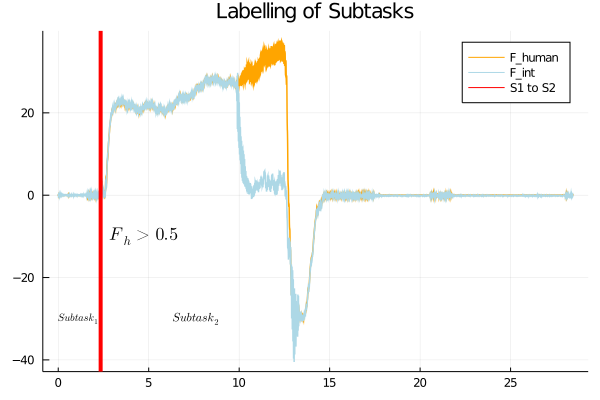

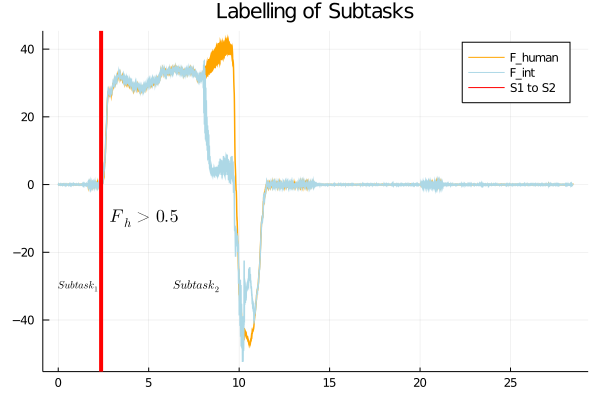

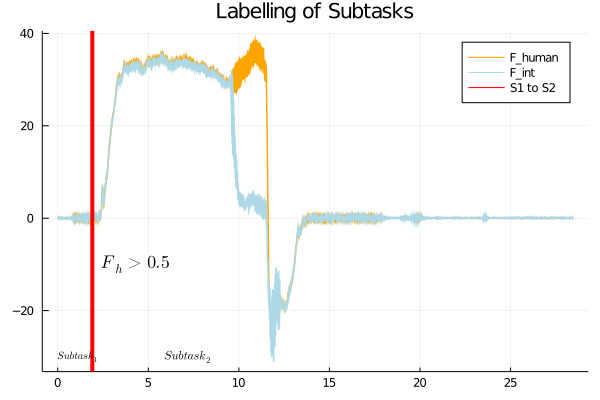

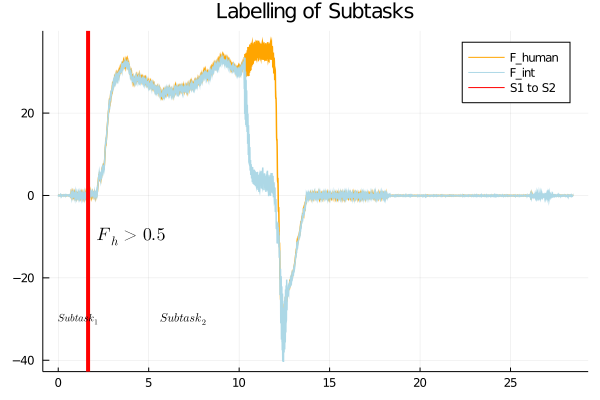

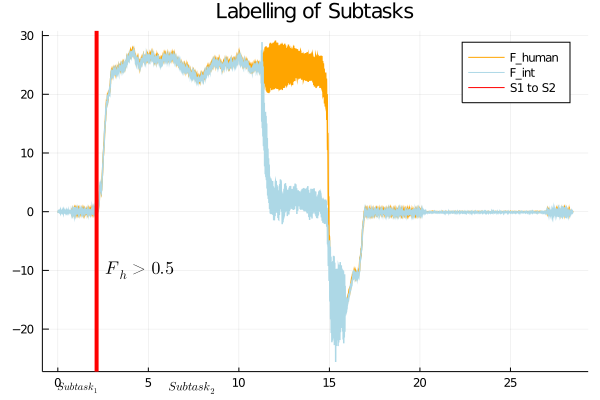

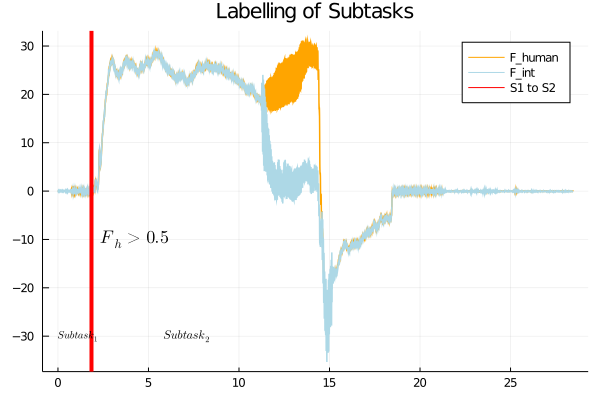

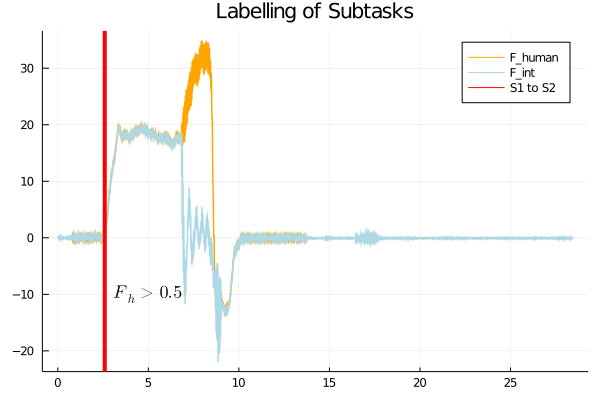

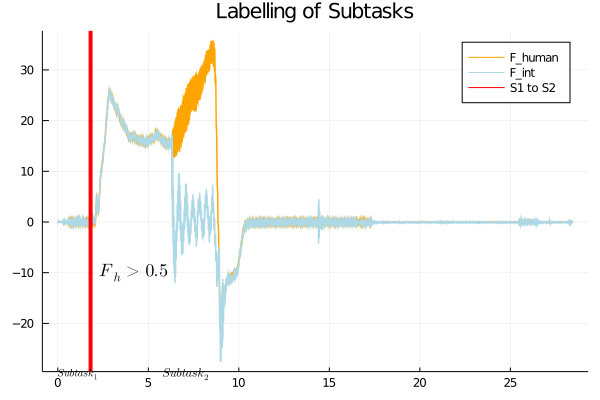

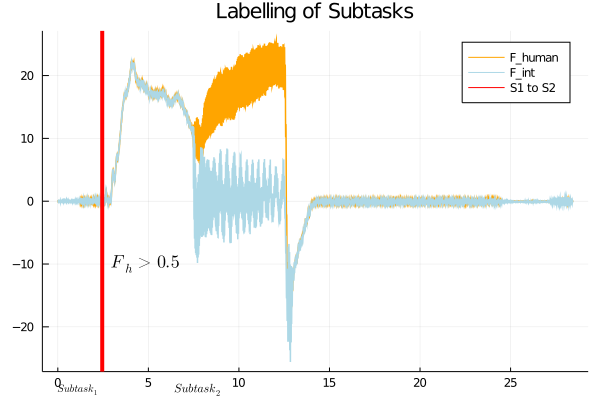

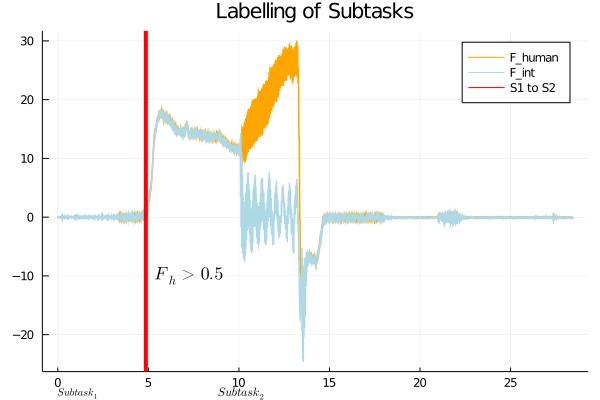

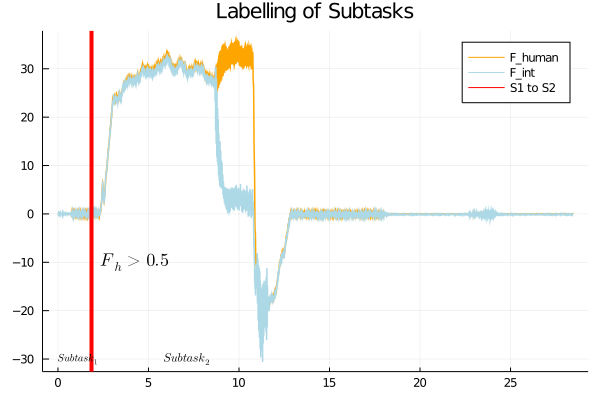

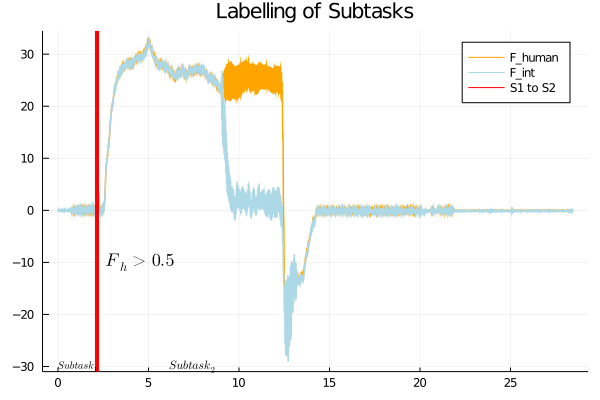

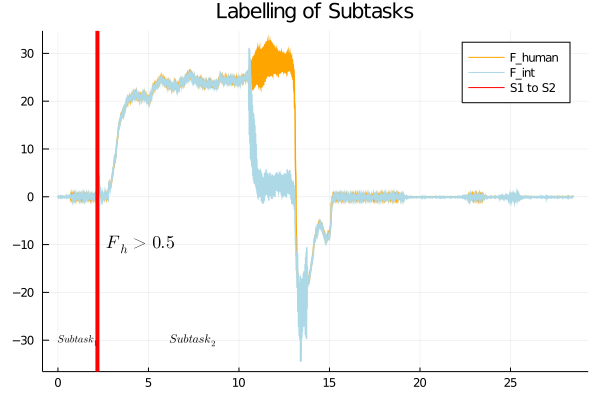

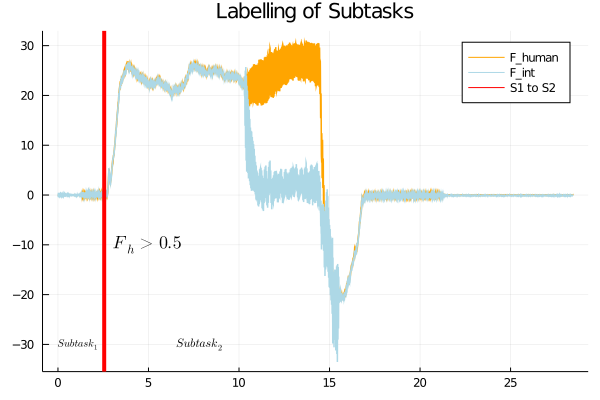

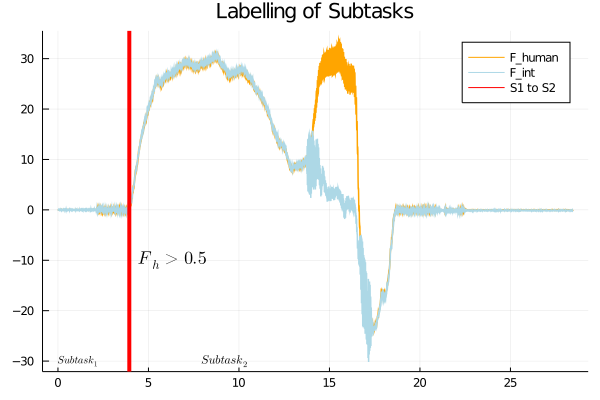

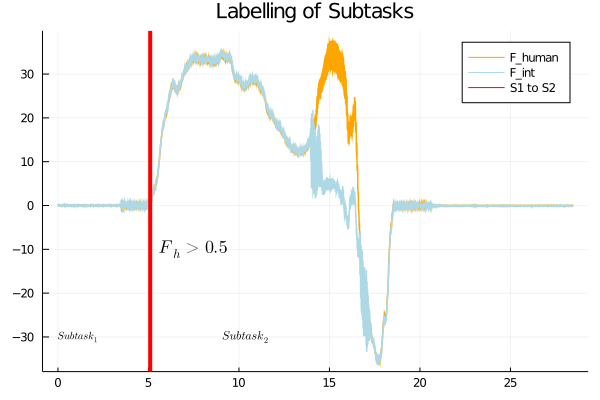

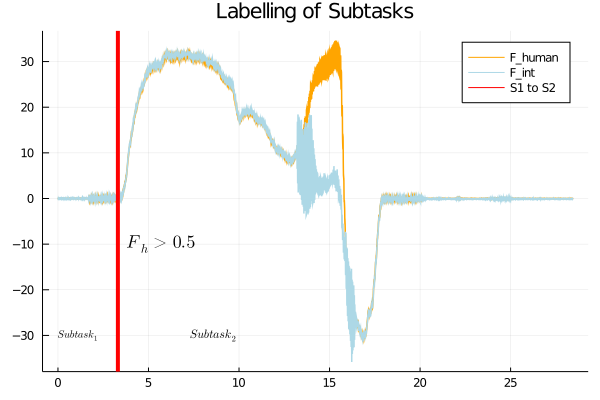

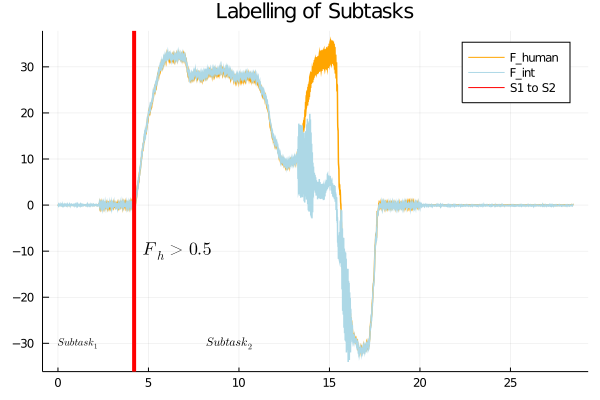

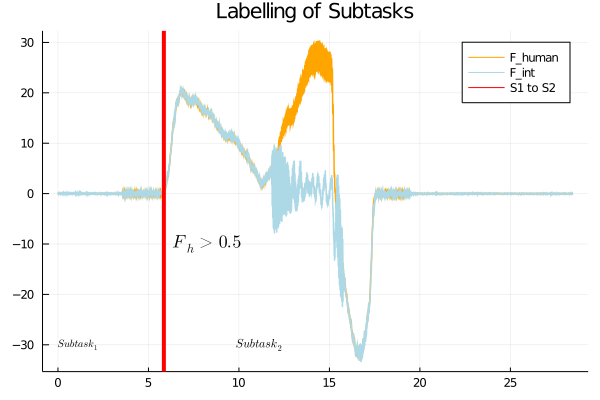

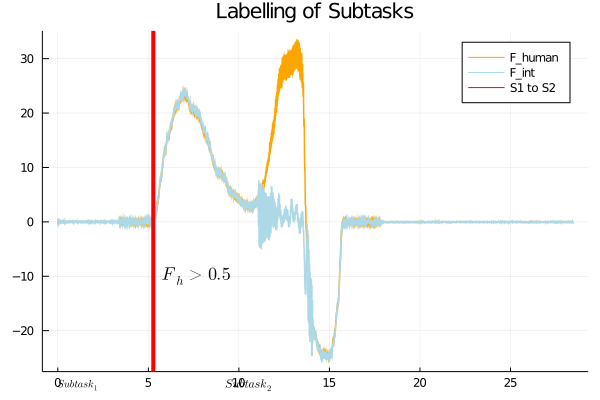

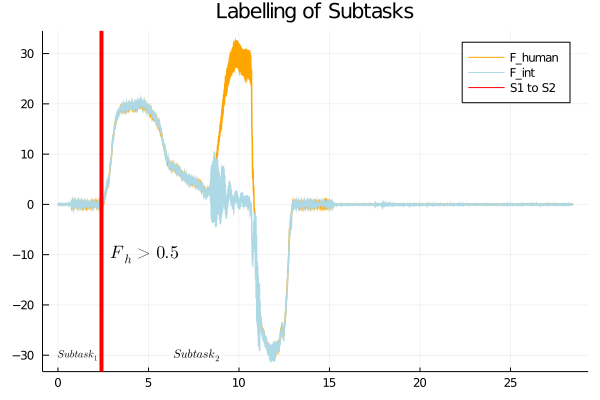

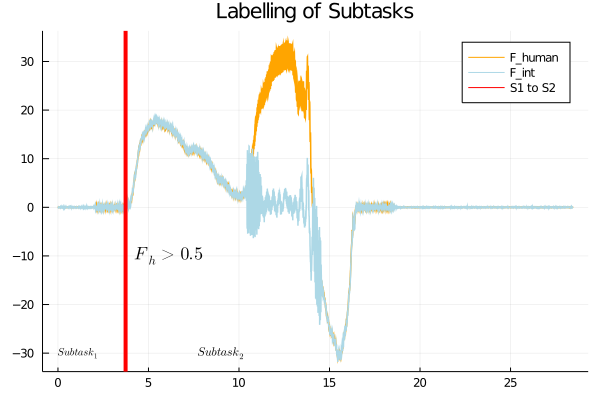

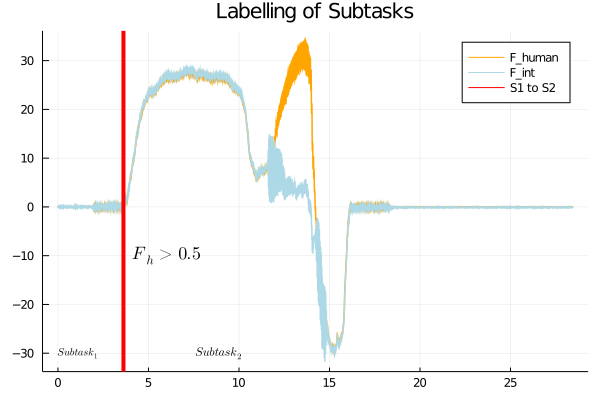

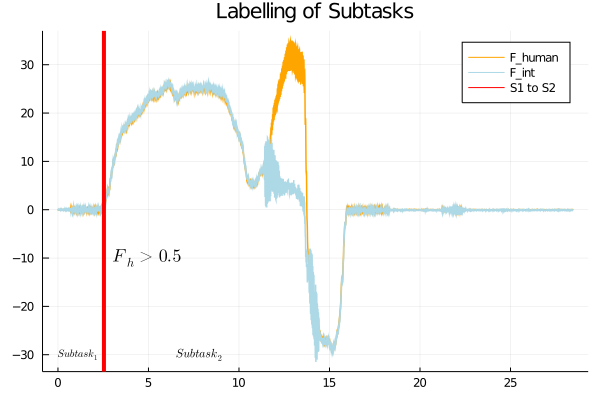

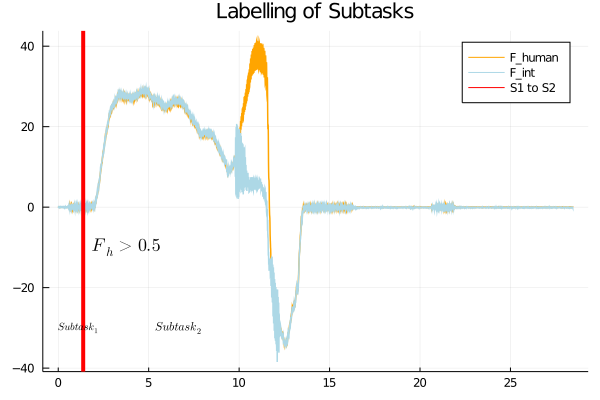

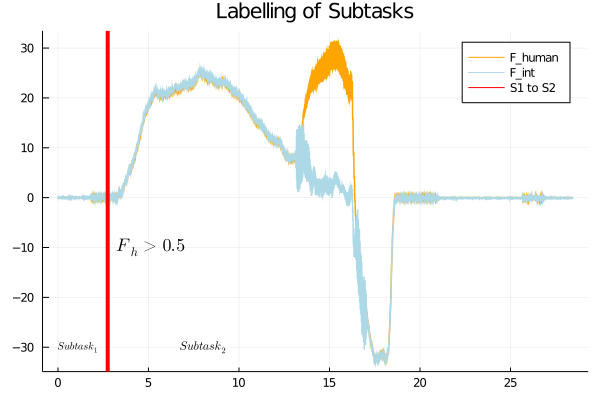

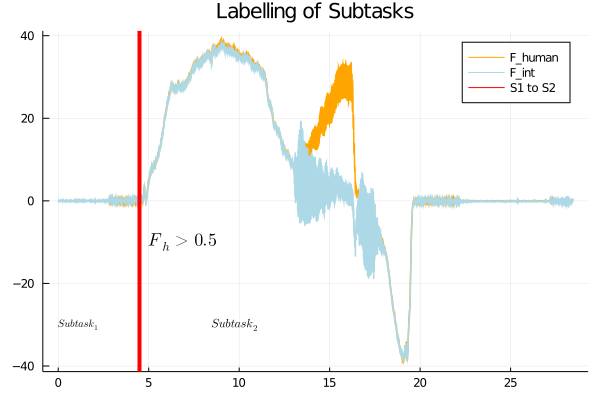

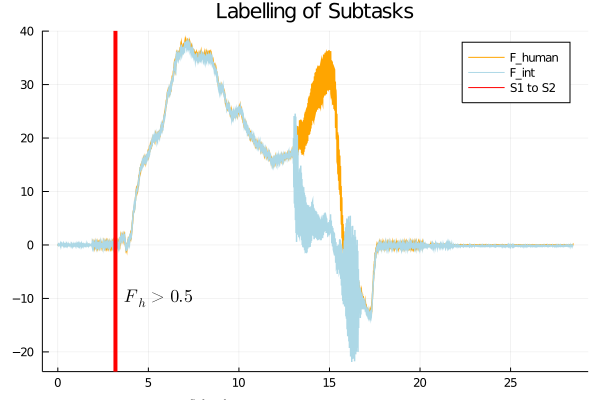

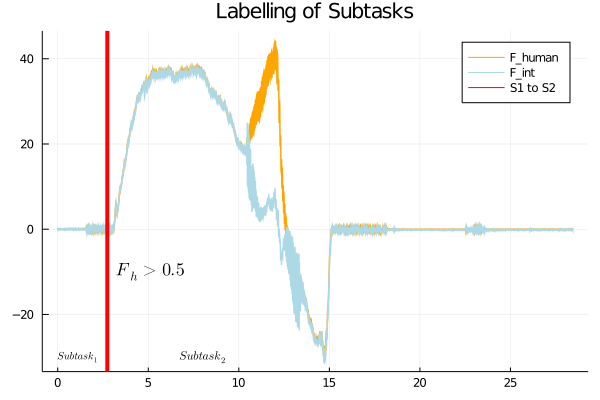

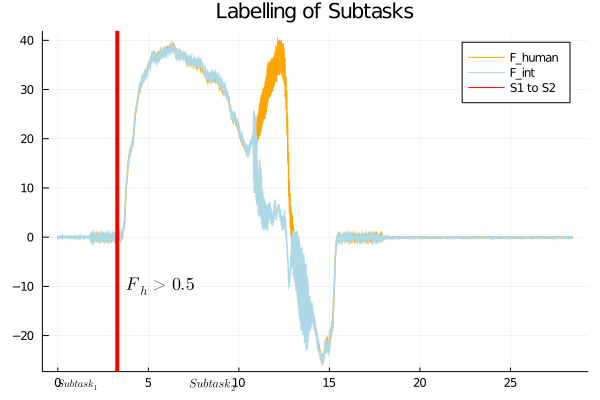

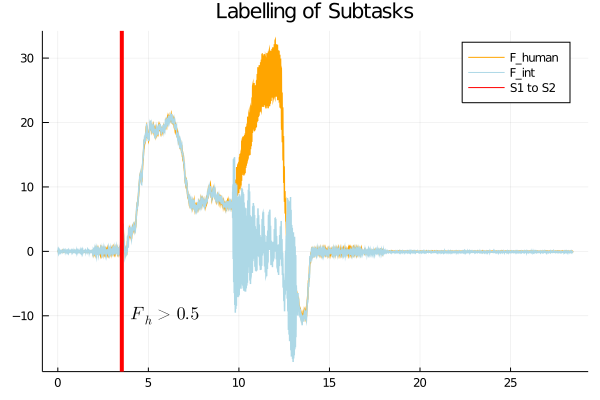

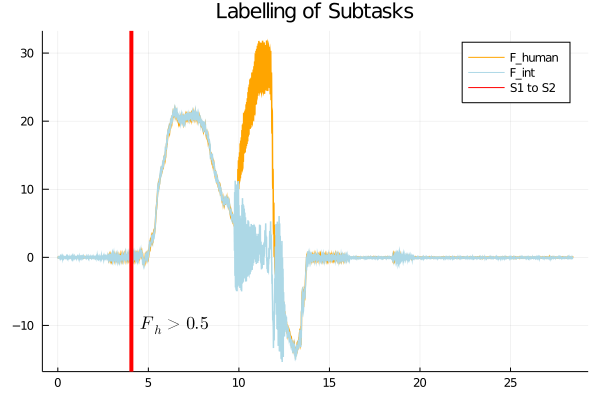

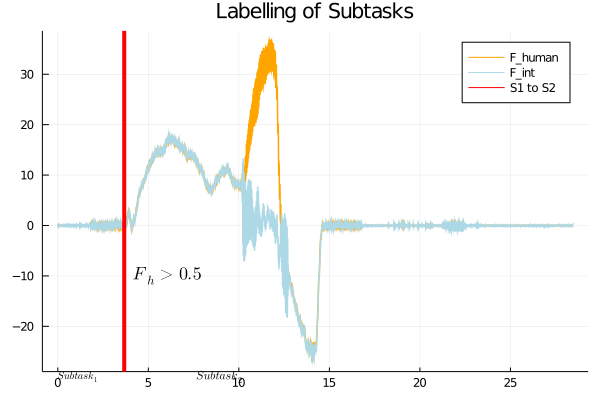

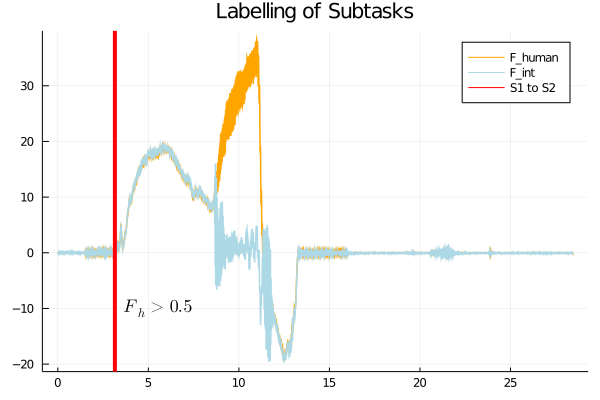

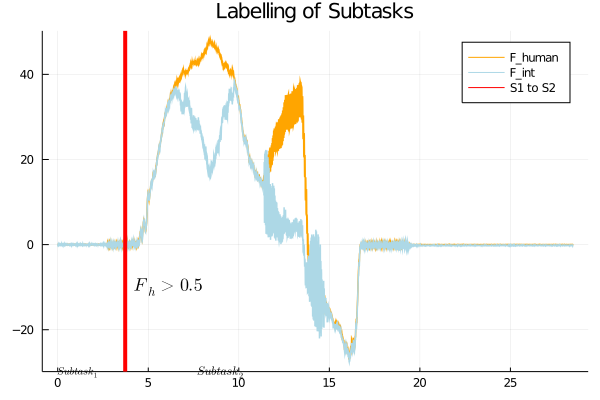

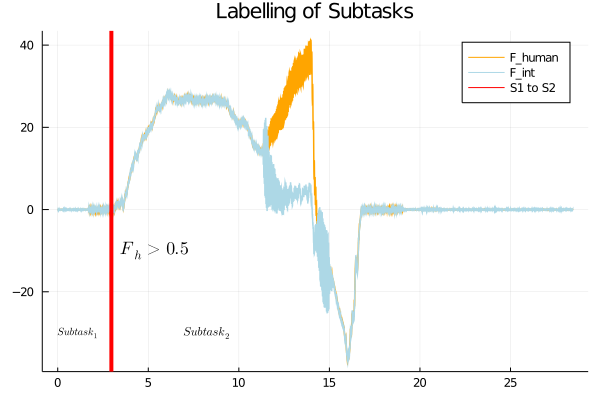

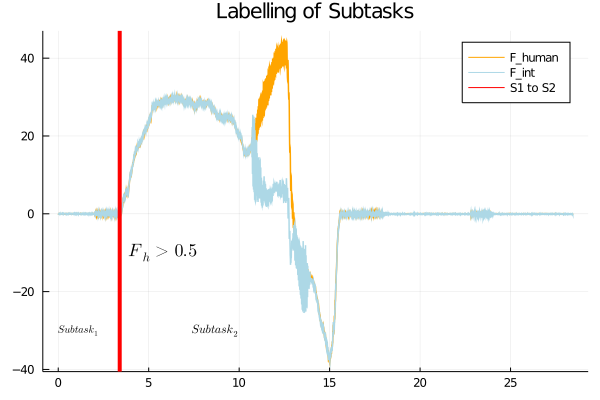

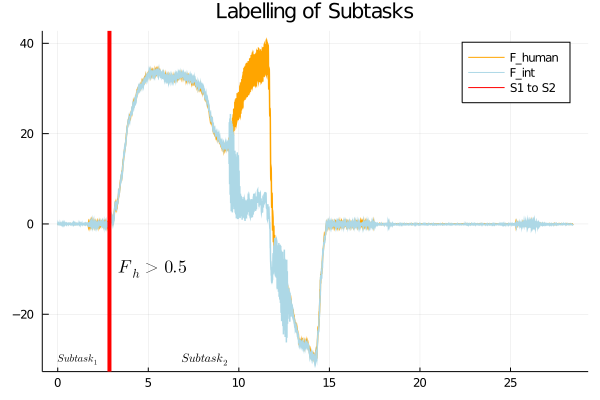

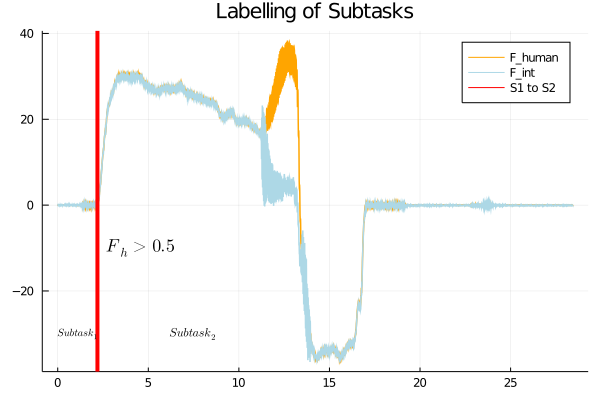

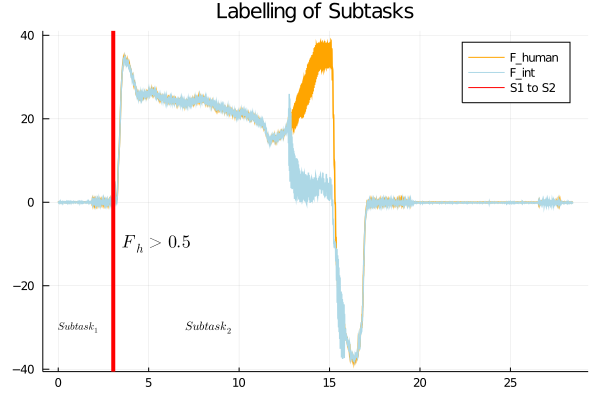

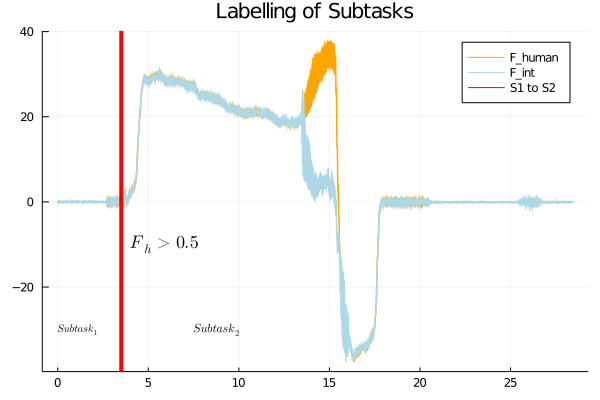

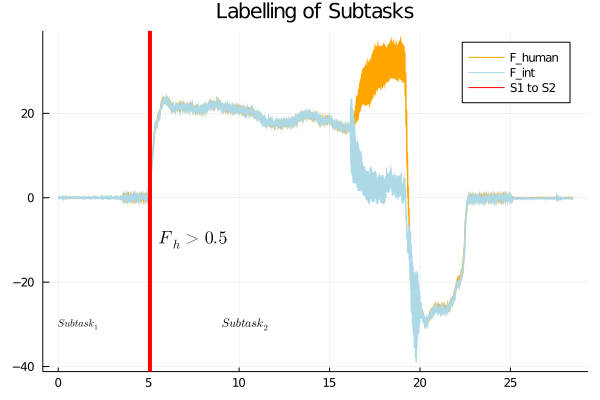

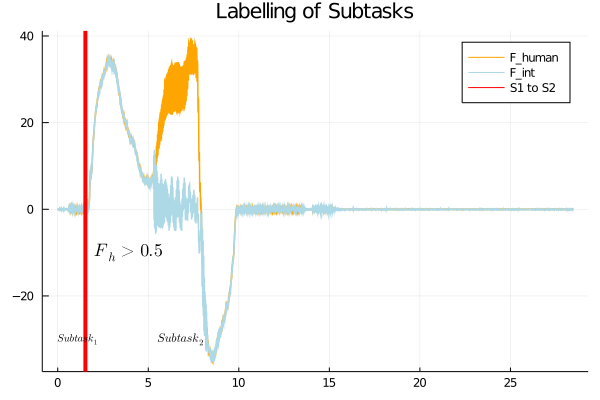

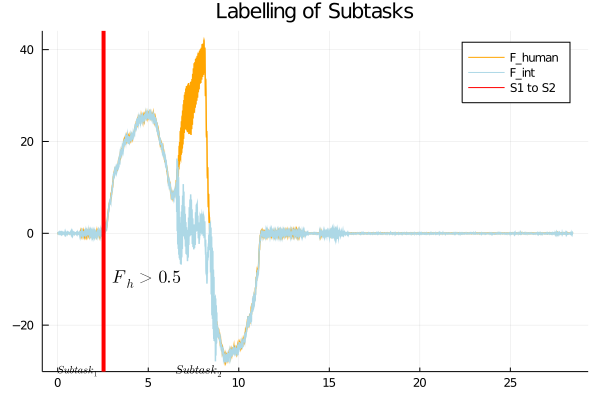

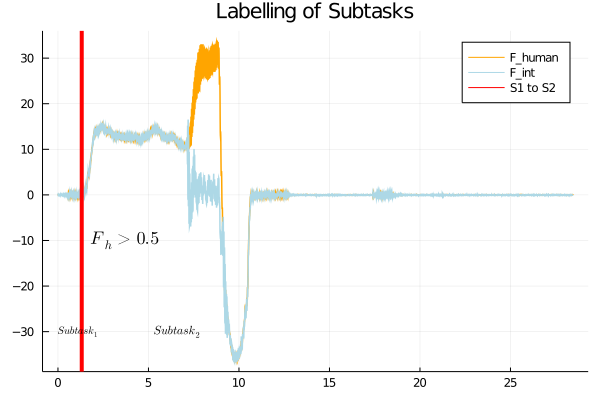

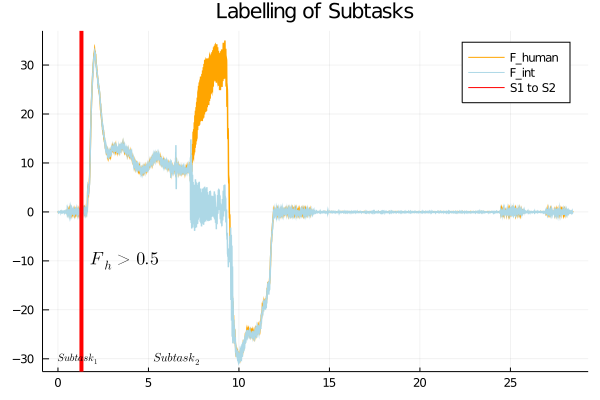

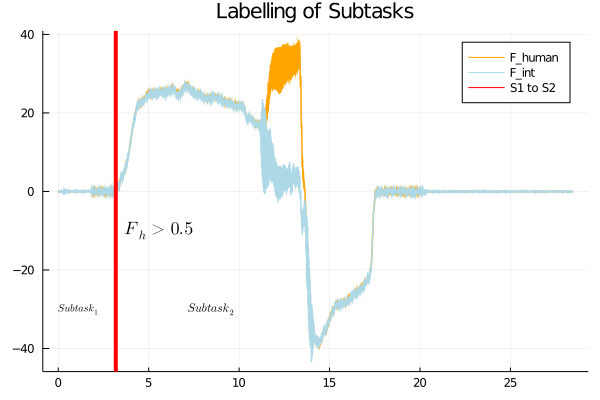

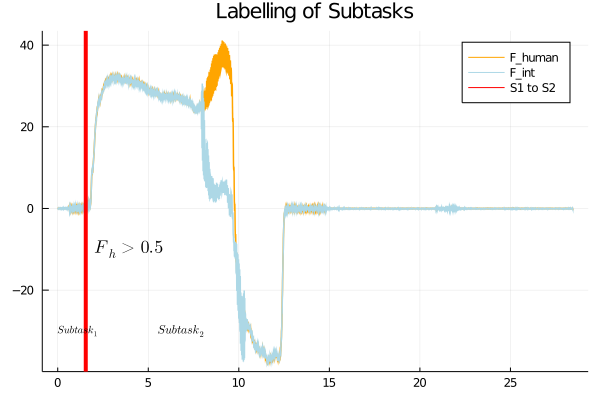

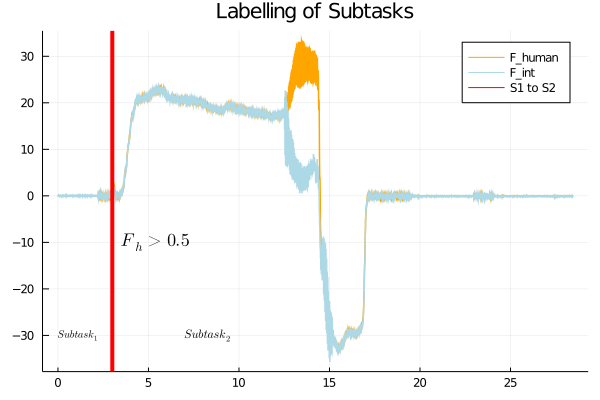

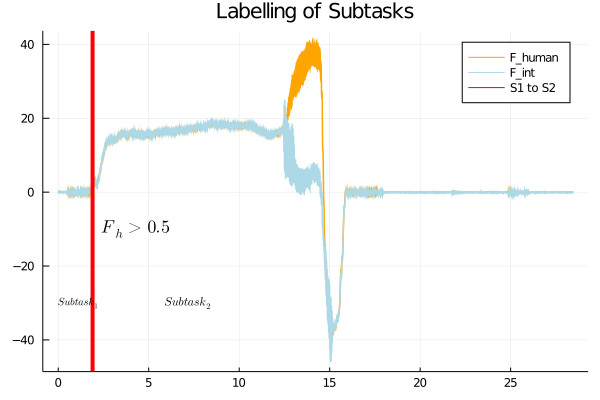

In [273]:
Y_selected = zeros(size(X_selected))

for index in 1:14224:size(X_selected,1)
    F_h = X[index:index+14224-1,12]
    F_int = X[index:index+14224-1,11]
    t =  X_selected[index:index+14224-1,1]
    a = (findall(x->x>0.5, F_h)[1])

    graph = plot(t,F_h, title = "Labelling of Subtasks",  label = "F_human" ,lw = 1.5, fmt = :png, linecolor = "Orange")
    plot!(t,F_int, label= "F_int", lw = 1.5, linecolor="LightBlue")
    plot!([t[a]], seriestype="vline", lw = 4, linecolor = "Red", label ="S1 to S2")
    annotate!(t[a]+0.5, -10, text("\$F_h > 0.5 \$",Plots.font("Tahoma", 12),  :left))
    annotate!(0, -30, text("\$Subtask_1 \$",Plots.font("Tahoma", 7),  :left))
    annotate!(t[a]+ 4, -30, text("\$Subtask_2 \$",Plots.font("Tahoma", 8),  :left))
    display(graph)
end